In [15]:
import cv2
import numpy as np
from split_image import split_image
import matplotlib.pyplot as plt

# Load the image
or_image = cv2.imread("two_angels.png")

# Convert to grayscale
gray = cv2.cvtColor(or_image, cv2.COLOR_BGR2GRAY)

# Apply Gaussian Blur
blur = cv2.GaussianBlur(gray, (5, 5), 0)

# gray = cv2.threshold(blur, 128, 255, cv2.THRESH_BINARY_INV)
# Adaptive Thresholding to reveal grid
thresh = cv2.adaptiveThreshold(
    blur, 255,
    cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
    cv2.THRESH_BINARY,
    11, 2
)
# cv2.imshow("Threshold", thresh)
# cv2.waitKey(0)

# Find initial contours (optional for isolating large area – skipped here)
# Instead, we go directly to clean grid contours:
contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Create output copy to draw on
output = or_image.copy()

# Loop through contours and filter squares
square_sizes = []
for cnt in contours:
    area = cv2.contourArea(cnt)
    if area > 4:  # You can adjust this value based on grid square size
        # Approximate contour to reduce noise
        approx = cv2.approxPolyDP(cnt, 0.015 * cv2.arcLength(cnt, True), True)

        if len(approx) == 4 and cv2.isContourConvex(approx):
            x, y, w, h = cv2.boundingRect(approx)
            aspect_ratio = float(w) / h

            # Only keep near-square shapes
            if aspect_ratio == 1:
                square_sizes.append((w,h))
                cv2.rectangle(output, (x, y), (x + w, y + h), (0, 255, 0), 1)

cv2.imshow("Filtered Square Contours", output)
cv2.waitKey(0)
cv2.destroyAllWindows()

# print("Detected square sizes (width x height in pixels):")
# for i, (w, h) in enumerate(square_sizes):
#     print(f"Square {i+1}: {w} x {h}")

# Average size
if square_sizes:
    avg_w = sum(w for w, h in square_sizes) / len(square_sizes)
    avg_h = sum(h for w, h in square_sizes) / len(square_sizes)
    print(f"\nAverage square size: {avg_w:.2f} x {avg_h:.2f} pixels")
else:
    print("No squares detected.")

avg_w = int(avg_w)
avg_h = int(avg_h)

# Draw grid overlay:
grid_img = or_image.copy()
height, width = or_image.shape[:2]
# for x in range(0, width, int(avg_w)):
#     cv2.line(grid_img, (x,0), (x,height), (0, 0, 255), 1)
# for y in range(0, height, int(avg_h)):
#     cv2.line(grid_img, (0,y), (width, y), (0, 0, 255), 1)

# cv2.imshow("Grid Overlay", grid_img)
# cv2.waitKey(0)
# cv2.destroyAllWindows()

quant = or_image.copy()

# Split into squares
for y in range(0, height, avg_h):
    for x in range(0, width, avg_w):
        square = quant[y:y+avg_h, x:x+avg_w]

# # Classify as black or white
# classification = []
# for y in range(0, height, avg):
#     row = []
#     for x in range(0, width, avg):
#         square = gray





Average square size: 11.13 x 11.13 pixels



Dynamic thresholds: black < 40.3, white > 130.3


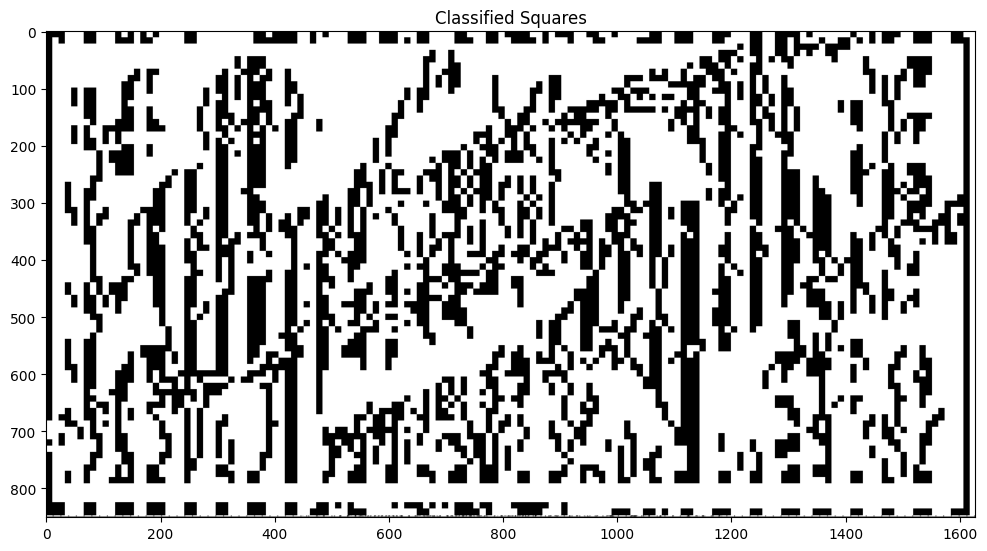

In [ ]:
# Calculate mean and std once
all_means = [gray[y:y+avg_h, x:x+avg_w].mean()
             for y in range(0, height, avg_h)
             for x in range(0, width, avg_w)
             if gray[y:y+avg_h, x:x+avg_w].shape == (avg_h, avg_w)]

mean_all = np.mean(all_means)
std_all = np.std(all_means)

threshold_black = mean_all - 0.5 * std_all
threshold_white = mean_all + 0.5 * std_all

print(f"\nDynamic thresholds: black < {threshold_black:.1f}, white > {threshold_white:.1f}")

# Classify each square
classification = []

for y in range(0, height, avg_h):
    row = []
    for x in range(0, width, avg_w):
        square = gray[y:y+avg_h, x:x+avg_w]

        if square.shape != (avg_h, avg_w):
            continue

        mean_intensity = square.mean()

        if mean_intensity < threshold_black:
            label = 'black'
        elif mean_intensity > threshold_white:
            label = 'white'
        else:
            label = 'uncertain'

        row.append(label)

        # Fill square with appropriate color
        color = (0, 0, 0) if label == 'black' else (255, 255, 255) if label == 'white' else (128, 128, 128)
        cv2.rectangle(quant, (x, y), (x + avg_w, y + avg_h), color, -1)

    classification.append(row)

# OrignaL vs Show classified grid
# Convert BGR to RGB for matplotlib
quant_rgb = cv2.cvtColor(quant, cv2.COLOR_BGR2RGB)

fig, ax = plt.subplots(1, 1, figsize=(10, 8))
ax.imshow(quant_rgb)
ax.set_title("Classified Squares")
plt.tight_layout()
plt.savefig("compare.png")
plt.show()